# Standard imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.integrate import odeint

# Custom imports that are either local or pulled from github

In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)
    
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'
        
        r = requests.get(url)
        print('Fetching from: ')
        print(r)
    
        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()
    
        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = package.__get_attr__(function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

# Imports related to model predictive control and pybounds

In [3]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    !pip install pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Planar drone dynamics. 

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} = 
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} + 
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} + 
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

<span style="color:blue;">AI tip: try an LLM to convert picture of your dynamics to latex. It'll get much of it right, but you may need to fix it. 

# Set some constant parameters (the blue symbols above)

In [4]:
m = 1 # mass (kg)
g = 9.81 # acceleration due to gravity (m/s^2)
L = 0.5 # length of the drone arm (m)
Iyy = 0.02 # moment of inertia (e.g. 1/12*m*L**2 for a solid rod, as an approximation)

# Define your dynamics function

We will use this same format many times, for evaluating observability and Kalman filters. 

<span style="color:blue;">AI tip: try an LLM to convert a picture of the dynamics, or the latex code, to a python function. You may have to correct it!

In [6]:
def f(x_vec, u_vec, m=m, g=g, L=L, I=Iyy):
    """
    Continuous time dynamics function for the system shown in the equation.
    
    Parameters:
    x_vec : array-like, shape (7,)
        State vector [θ, θ̇, x, ẋ, z, ż, k]
    u_vec : array-like, shape (2,)
        Control vector [j1, j2]
    L : float, default 0.5
        drone arm length
    m : float, default 1.0
        drone mass
    g : float, default 9.81
        Gravitational acceleration
    
    Returns:
    x_dot : numpy array, shape (7,)
        Time derivative of state vector
    """
    
    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]
    
    # f0 component: drift dynamics (no controls)
    f0_contribution = np.array([ theta_dot, 
                                 0, 
                                 x_dot, 
                                 0, 
                                 z_dot, 
                                 -g / m, 
                                 0])
    
    # f1 component: multiplied by control j1
    f1_contribution = j1 * np.array([0, 
                                     L*k/Iyy, 
                                     0, 
                                     0, 
                                     0, 
                                     0, 
                                     0])
    
    # f2 component: multiplied by control j2
    f2_contribution = j2 * np.array([0,
                                     0,
                                     0,
                                     -k * np.sin(theta) / m,
                                     0,
                                     k * np.cos(theta) / m,
                                     0])

    # combined dynamics
    x_dot_vec = f0_contribution + f1_contribution + f2_contribution
    
    return x_dot_vec

In [7]:
# # sim time
# dt = 0.01
# tsim = np.arange(0, 8.0, step=dt)

In [8]:
# # initial condition
# x0 = np.array([0, 0, 0, 0, 10, 0, 1])

# Planar drone measurements

Define a measurement function. In this case we consider $\mathbf{y}$ consisting of a downward facing camera that records ventral optic flow, and a measurement of the tilt of the planar drone. 

$
\mathbf{y} = 
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta}
\end{bmatrix}
$

In [10]:
def h(x_vec, u_vec):
    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    accel_x = -k*L/Iyy*j1 - k*np.sin(theta)*j2 / m
    accel_z = -g + k*np.cos(theta)*j2 / m
    
    # Measurements
    y_vec = [x_dot/z, theta, accel_x, accel_z]

    # Return measurement
    return y_vec

# Simulate with pybounds / MPC

In [11]:
import pybounds

In [12]:
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']
input_names = ['j1', 'j2']
measurement_names = ['optic_flow', 'theta', 'accel_x', 'accel_z']

In [13]:
dt = 0.1  # [s]

In [14]:
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names, 
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


In [15]:
# First define the set-point(s) to follow
tsim = np.arange(0, 8.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 1.0*np.cos(2*np.pi*tsim*0.3),  # ground speed changes as a sinusoid
            'x_dot': NA,
            'z': 0.3*np.sin(2*np.pi*tsim*0.2)+0.5, # altitude also oscillates
            'z_dot': NA,
            'k': np.ones_like(tsim),
           }

In [16]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [17]:
# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_x + cost_z

In [18]:
# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

In [19]:
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0

simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

In [20]:
# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

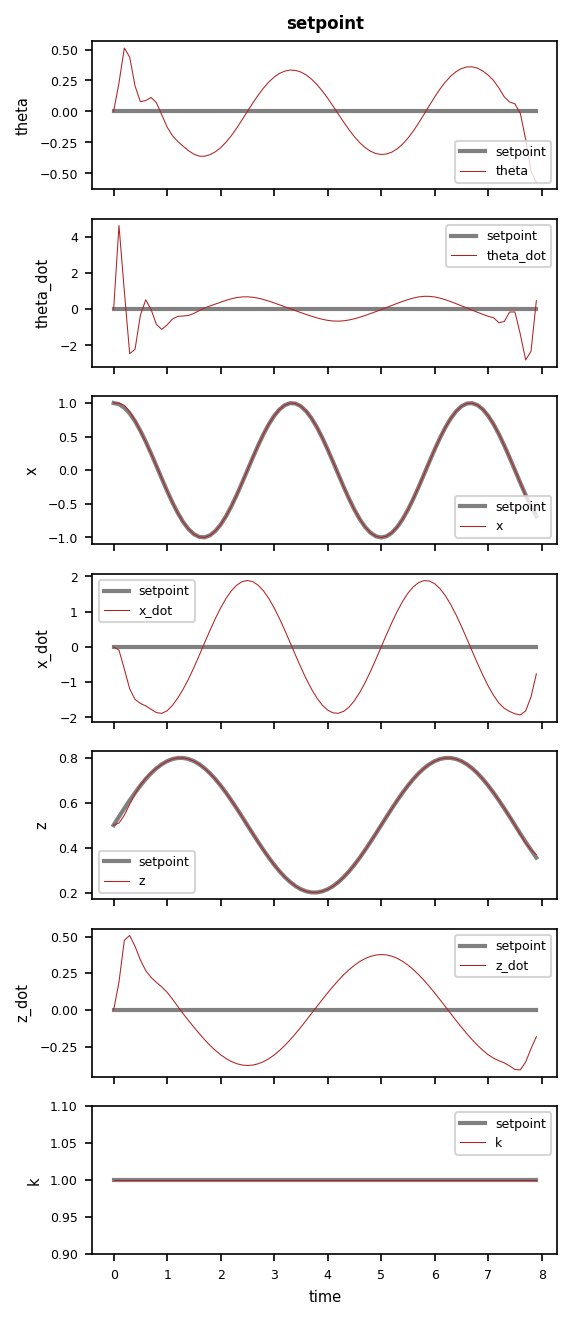

In [21]:
simulator.plot('setpoint')

# rebuild y from h and x, y

In [ ]:
x_sim_df = pandas.DataFrame(x_sim)
u_sim_df = pandas.DataFrame(u_sim)
y_sim_df = pandas.DataFrame(y_sim)

# Compare simulator y_sim to h(x_k, u_k)

In [ ]:
y_from_h = []
for i in range(x_sim_df.shape[0]):
    y = h(x_sim_df.values[i,:], u_sim_df.values[i,:])
    y_from_h.append(y)

y_from_h = np.vstack(y_from_h)

Text(0, 0.5, 'optic flow')

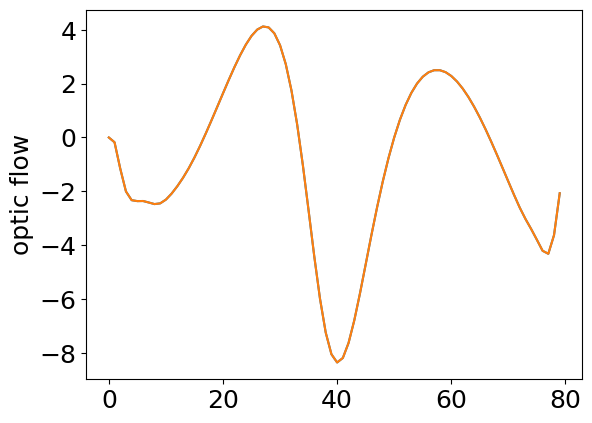

In [31]:
plt.plot(y_sim_df.values[:,0])
plt.plot(y_from_h[:,0])
plt.ylabel('optic flow')

Text(0, 0.5, 'accel_x')

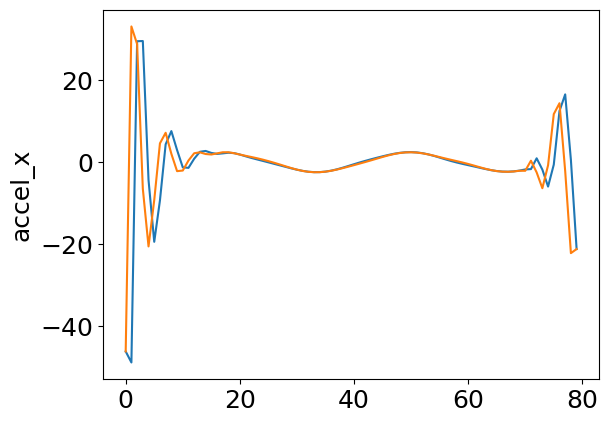

In [32]:
plt.plot(y_sim_df.values[:,2])
plt.plot(y_from_h[:,2])
plt.ylabel('accel_x')

# Compare simulator y_sim to h(x_k, u_[k-1])

In [33]:
y_from_h_delay = []
for i in range(1, x_sim_df.shape[0]):
    y = h(x_sim_df.values[i,:], u_sim_df.values[i-1,:])
    y_from_h_delay.append(y)

y_from_h_delay = np.vstack(y_from_h_delay)

Text(0, 0.5, 'optic flow')

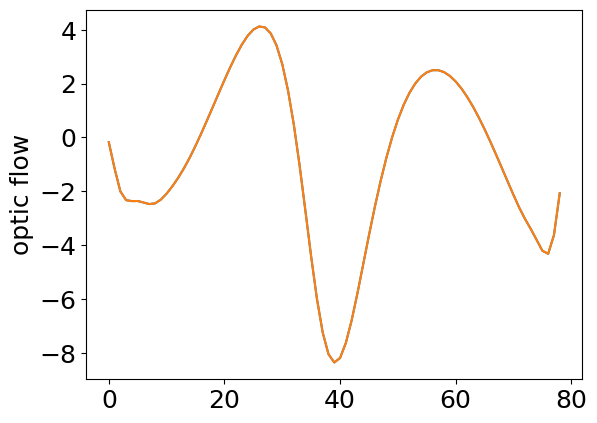

In [37]:
plt.plot(y_sim_df.values[1:,0])
plt.plot(y_from_h_delay[:,0])
plt.ylabel('optic flow')

Text(0, 0.5, 'accel_x')

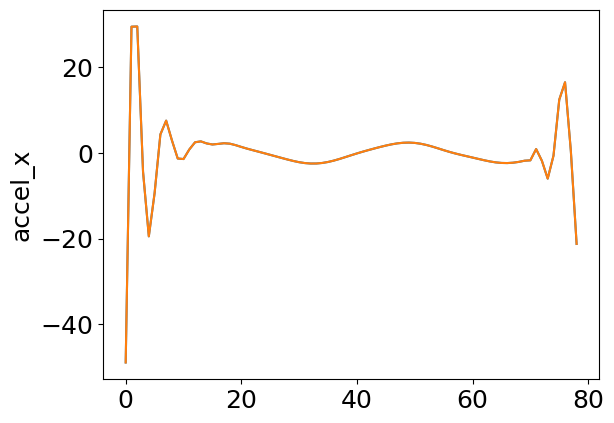

In [36]:
plt.plot(y_sim_df.values[1:,2])
plt.plot(y_from_h_delay[:,2])
plt.ylabel('accel_x')